<a href="https://colab.research.google.com/github/mraarabzadeh/University_prj/blob/master/PCA_LSTM_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install ta

  Created wheel for ta: filename=ta-0.5.25-cp36-none-any.whl size=24880 sha256=5e4206051e65d00f107add45b3ab4bebfa0f0a112cdd459ea1931cb7edded11b
  Stored in directory: /root/.cache/pip/wheels/2e/93/b7/cf649194508e53cee4145ffb949e9f26877a5a8dd12db9ed5b
Successfully built ta


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# from skcuda.linalg import PCA as cuPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ta.volatility import AverageTrueRange, BollingerBands
from ta.trend import EMAIndicator
from ta.momentum import UltimateOscillator, StochasticOscillator, ROCIndicator, RSIIndicator, WilliamsRIndicator
from statsmodels.tsa.arima_model import ARIMA
WS = 20

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/newbit.csv').dropna()
df = df.iloc[[x for x in range(0,20000,10)]]

In [0]:
class Bitcoin(nn.Module):
    def __init__(self,inSize, hiddenSize, outSize, ws):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.inSize = inSize
        self.ws = ws
        lstm = []
        for i,item in enumerate(hiddenSize):
            lstm.append(nn.LSTM(inSize,hiddenSize[i],num_layers=2,dropout=.2))
            inSize = hiddenSize[i]
        self.lstm = nn.ModuleList(lstm)
        self.linear = nn.Linear(hiddenSize[-1], outSize)
        self.reset()
    def reset(self):
        self.hiddenMemory =[]
        for item in self.hiddenSize:
            self.hiddenMemory.append((torch.zeros(2,1,item).cuda(),\
                            torch.zeros(2,1,item).cuda()))
    def forward(self,seq):
        seq=seq.view(self.ws, -1, self.inSize)
        for i,item1 in enumerate(self.hiddenMemory):
            seq ,self.hiddenMemory[i]= self.lstm[i](seq, self.hiddenMemory[i])
        x = self.linear(seq)
        return x[-1]

In [0]:
def make_input(seq,ws, st_col=0, end_col=0):
    output = []
    for item in range(len(seq) - ws):
        if st_col == end_col == 0:
            output.append( ((seq[item:item+ws].reshape(1,-1)[0].cuda()),\
                            torch.FloatTensor(np.array(seq[item + ws:item + ws+1][-1][-1])).cuda()) )
        else:
            output.append(((torch.FloatTensor(pd.DataFrame([x[st_col:end_col] for x in seq[item:item+ws]]).values.astype(float).reshape(1,-1)[0]).cuda()),\
                            torch.FloatTensor(np.array(seq[item + ws:item + ws+1][-1][-1])).cuda()))
    return output



In [0]:
def PCA_function(data_frame, n_components):
    sc = StandardScaler()
    X_train = sc.fit_transform(data_frame)
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    return X_train


In [0]:
def arima_model(data):
    return ARIMA(data, order=(1,1,1)).fit().forecast(steps=1)[0]



In [0]:
def add_indicators():
    added_columns = ['MA5','MA10','MA20', 'DIFF', 'BU', 'BL', 'Stochastic', \
                 'ROC', 'RSI6', 'RSI12', 'ATR', 'WR5', 'WR10', 'UOS'\
                     'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', \
                      'I28', 'I29'   ]
    close = df['Close']
    df['MA5'] = close.rolling(window=5).mean()
    df['MA10'] = close.rolling(window=10).mean()
    df['MA20'] = close.rolling(window=20).mean()
    df['DIFF'] = EMAIndicator(close, n=12).ema_indicator() - EMAIndicator(close, n=26).ema_indicator()
    df['BL']=BollingerBands(close, n=20, ndev=2).bollinger_lband()
    df['BU']=BollingerBands(close, n=20, ndev=2).bollinger_hband()
    df['Stochastic']=StochasticOscillator(df['High'], df['Low'], close).stoch()
    df['ROC'] = ROCIndicator(close).roc()
    df['RSI6'] = RSIIndicator(close, 6).rsi()
    df['RSI12'] = RSIIndicator(close, 12).rsi()
    df['ATR'] = AverageTrueRange(df['High'],df['Low'], close).average_true_range() 
    df['WR10'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=10).wr()
    df['WR5'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=5).wr()
    df['UOS'] = UltimateOscillator(df['High'],df['Low'], close,).uo()
    df['I28'] = close.diff(1) / close.shift(1)
    df['I29'] = (close - df['Open']) / df['Open']
    df['I30'] = (close - df['High']) / (df['High'] - df['Low'])
    df['I31'] = df['MA5'].diff(1) / df['MA5'].shift(1)
    df['I32'] = df['MA10'].diff(1) / df['MA10'].shift(1)
    df['I33'] = df['MA20'].diff(1) / df['MA20'].shift(1)
    df['I34'] = df['MA5'].diff(1) / df['MA20'].shift(1)
    df['I35'] = (close - np.array([np.amin(close[:x]) for x in range(len(close))]))/np.array([np.amin(close[:x]) for x in range(len(close))])
    df['I36'] = (close - np.array([np.amax(close[:x]) for x in range(len(close))]))/np.array([np.amax(close[:x]) for x in range(len(close))])
    df.dropna(inplace= True)
    return added_columns


In [0]:
instance = Bitcoin(10,[200,300,100],1,WS).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(instance.parameters(), lr = .001)
torch.manual_seed(33)

traincol = ['Open','High','Low', 'Close', 'Volume_(Currency)', 'Weighted_Price']
resultCol = ['Weighted_Price']


In [0]:
scaler = MinMaxScaler(feature_range=(-1, 1 ))
add_indicators()
new_df = np.array(PCA_function(df, 10))
new_df=np.append(new_df, df['Close'].values.astype(float).reshape(-1,1), axis=1)
new_df = pd.DataFrame(data=new_df)
train_set = np.array(new_df.values.astype(float))#.reshape(-1,1)
train_set = scaler.fit_transform(train_set)
# train_set = torch.FloatTensor(train_set)
train_set = make_input(train_set, WS, st_col=0, end_col=10)
# test = df[resultCol][-100:].values.astype(float)#.reshape(-1,1)
# test = scaler.fit_transform(test)
# test = torch.FloatTensor(test)
# test = make_input(test,WS)
test = train_set[-200:]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


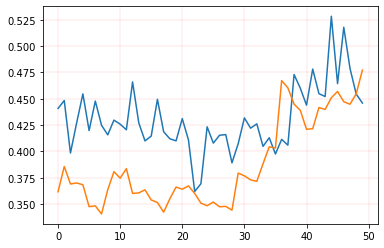

0 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


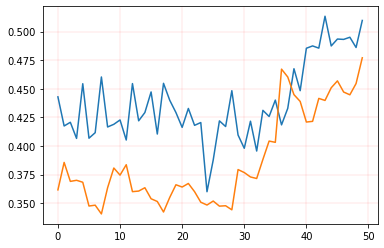

1 tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward>)


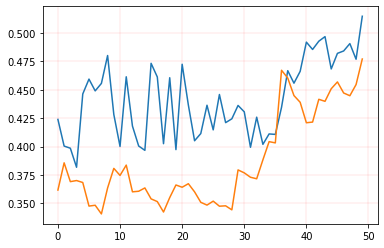

2 tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward>)


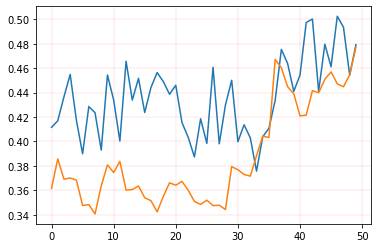

3 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)


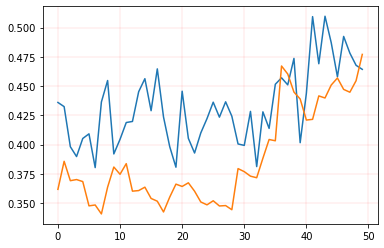

4 tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)


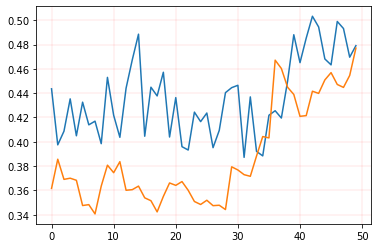

5 tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward>)


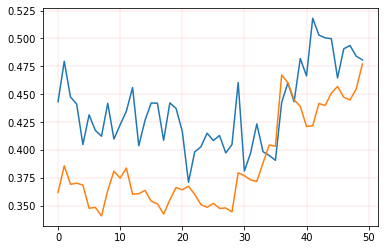

6 tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)


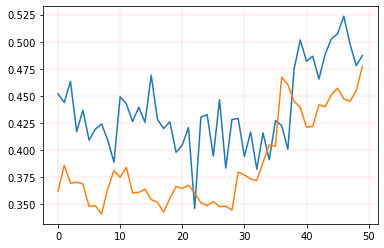

7 tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)


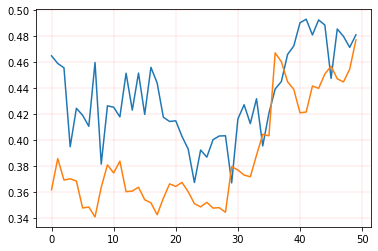

8 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)


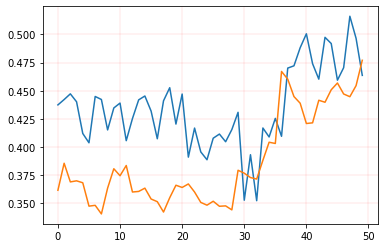

9 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


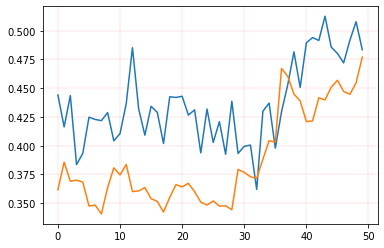

10 tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward>)


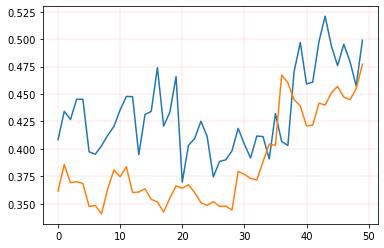

11 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


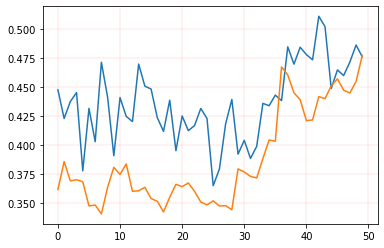

12 tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)


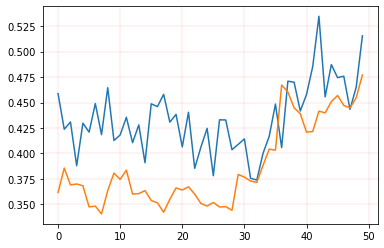

13 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


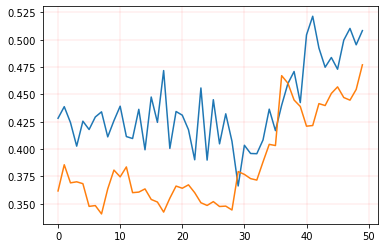

14 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)


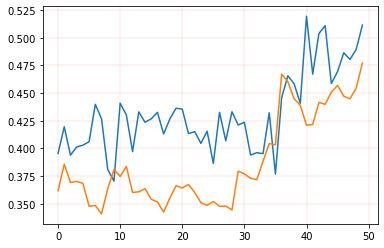

15 tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


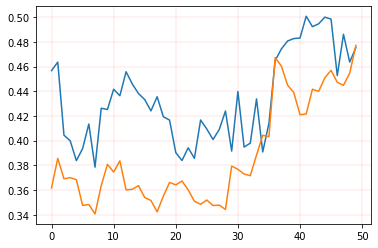

16 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)


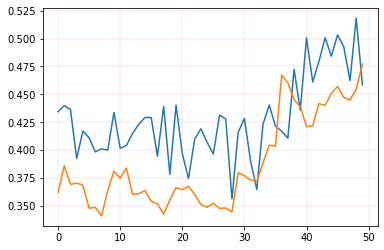

17 tensor(5.8495e-06, device='cuda:0', grad_fn=<MseLossBackward>)


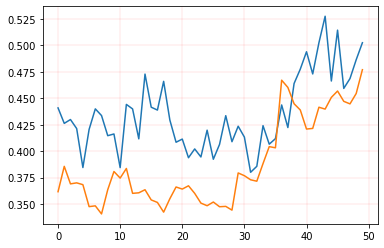

18 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)


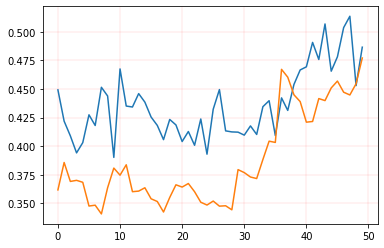

19 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)


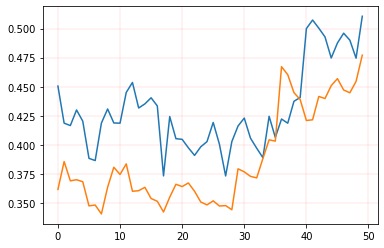

20 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


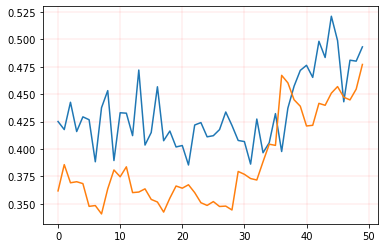

21 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)


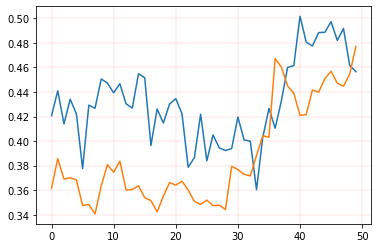

22 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)


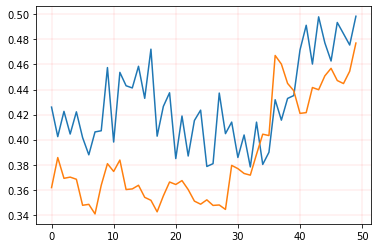

23 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)


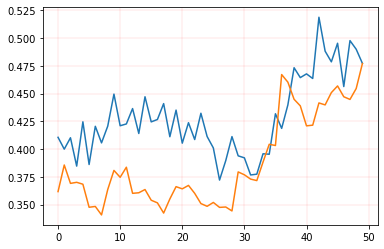

24 tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


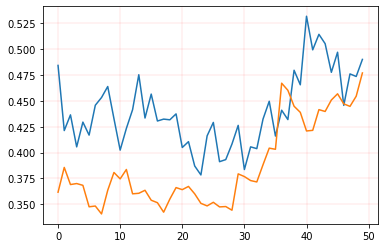

25 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)


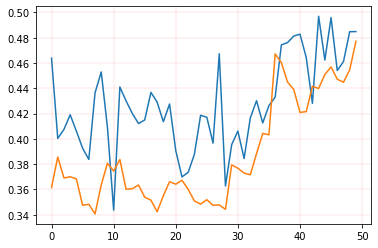

26 tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)


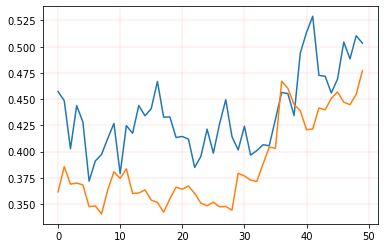

27 tensor(5.5252e-05, device='cuda:0', grad_fn=<MseLossBackward>)


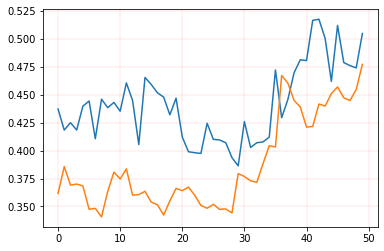

28 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


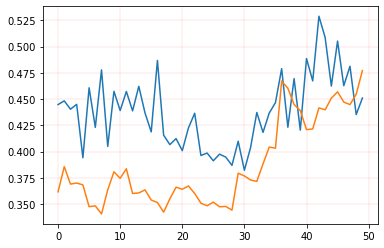

29 tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)


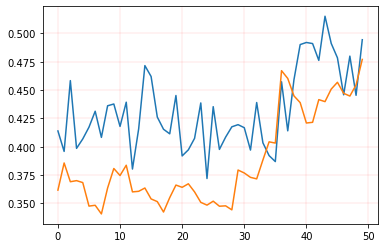

30 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


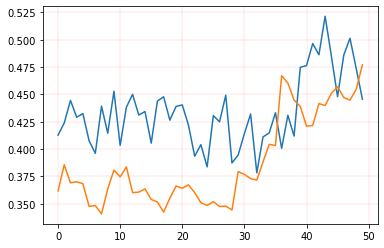

31 tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)


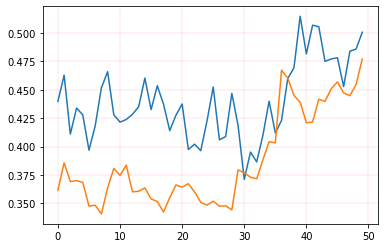

32 tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward>)


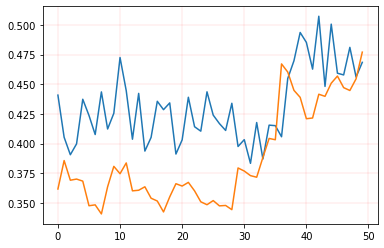

33 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


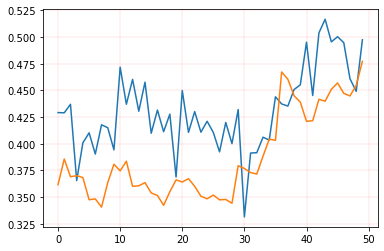

34 tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)


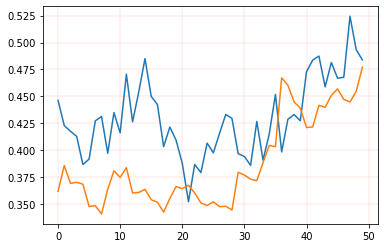

35 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)


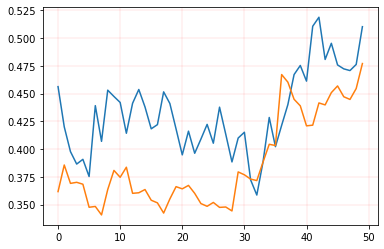

36 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


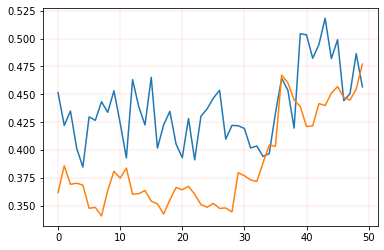

37 tensor(7.8364e-06, device='cuda:0', grad_fn=<MseLossBackward>)


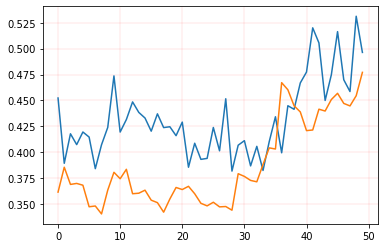

38 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


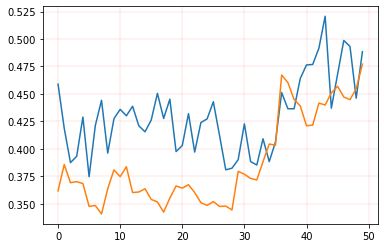

39 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


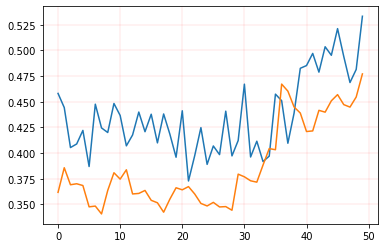

40 tensor(4.5442e-05, device='cuda:0', grad_fn=<MseLossBackward>)


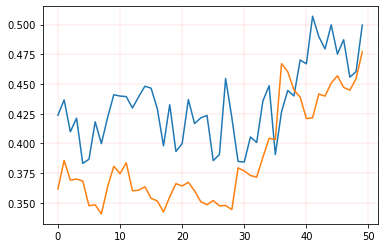

41 tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)


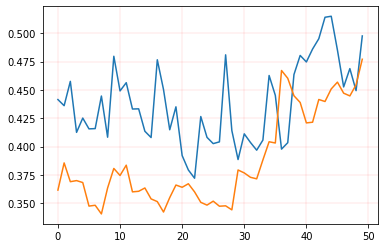

42 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)


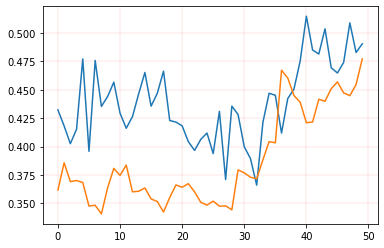

43 tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)


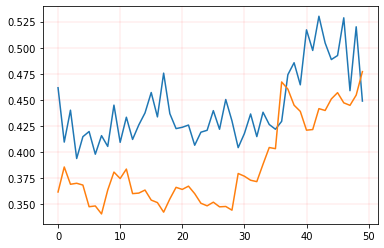

44 tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward>)


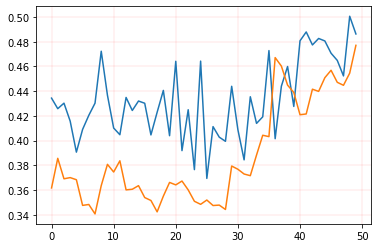

45 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


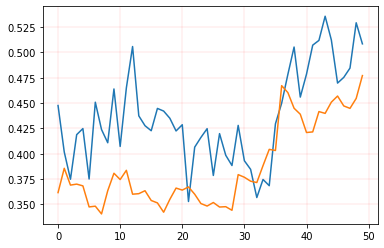

46 tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward>)


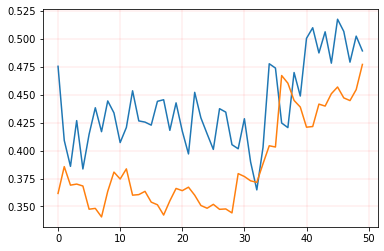

47 tensor(1.2379e-05, device='cuda:0', grad_fn=<MseLossBackward>)


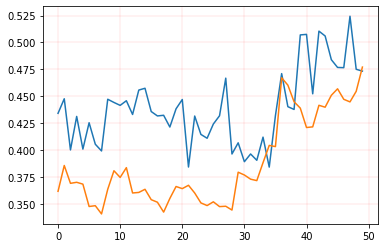

48 tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


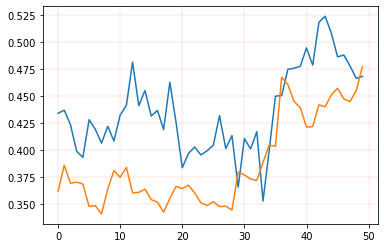

49 tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward>)


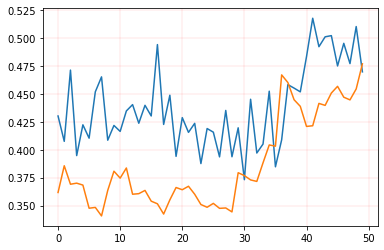

50 tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)


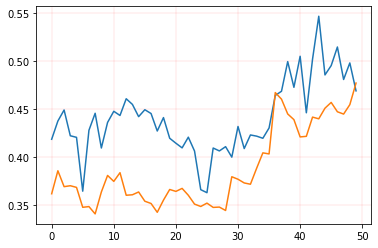

51 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


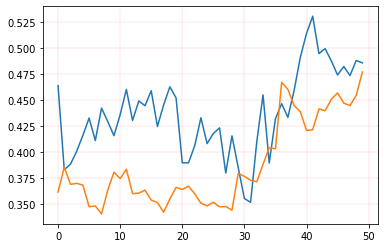

52 tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward>)


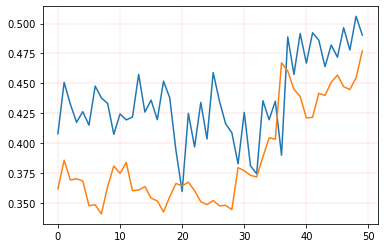

53 tensor(7.7875e-05, device='cuda:0', grad_fn=<MseLossBackward>)


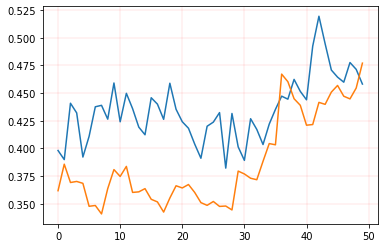

54 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


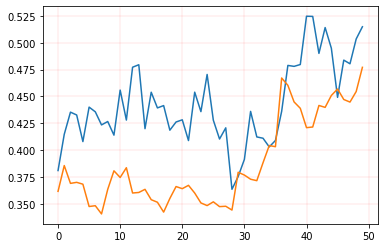

55 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)


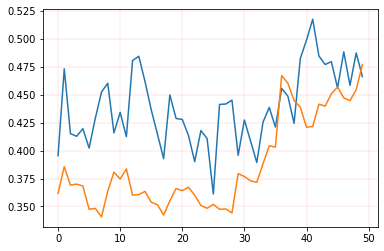

56 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


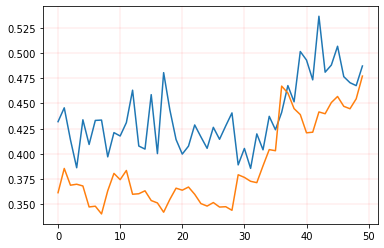

57 tensor(6.5769e-07, device='cuda:0', grad_fn=<MseLossBackward>)


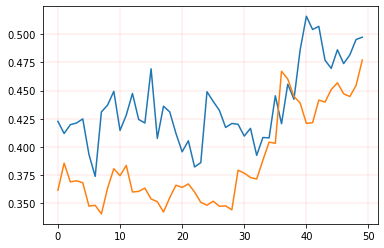

58 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)


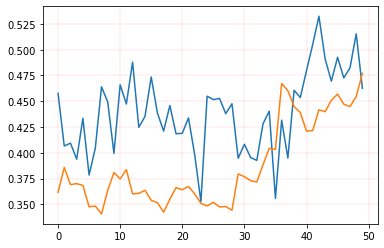

59 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)


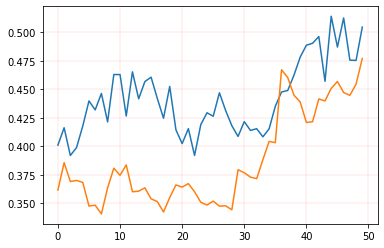

60 tensor(6.6750e-05, device='cuda:0', grad_fn=<MseLossBackward>)


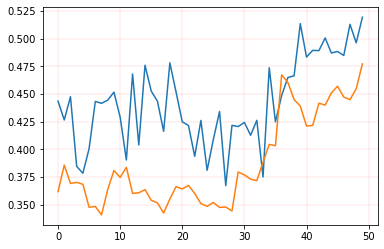

61 tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward>)


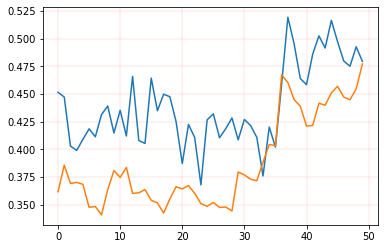

62 tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward>)


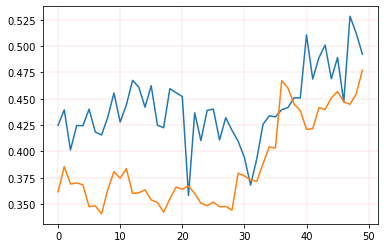

63 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)


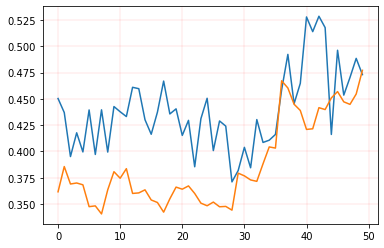

64 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


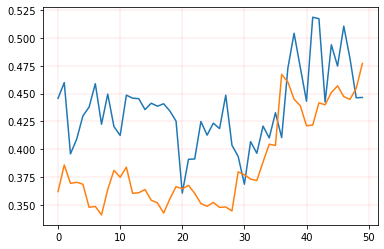

65 tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


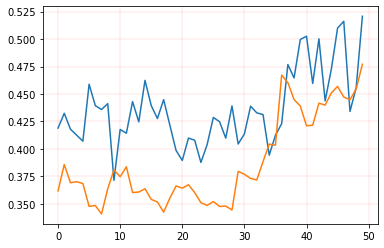

66 tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward>)


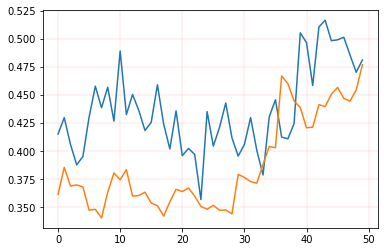

67 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)


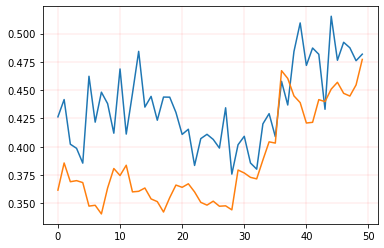

68 tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward>)


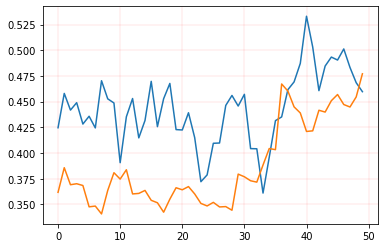

69 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


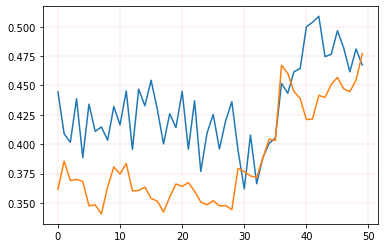

70 tensor(6.3495e-05, device='cuda:0', grad_fn=<MseLossBackward>)


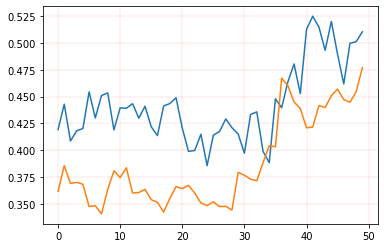

71 tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>)


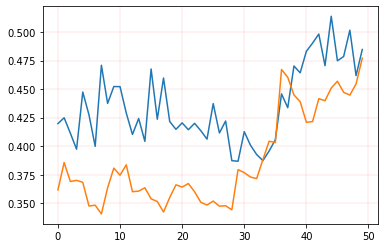

72 tensor(5.5168e-05, device='cuda:0', grad_fn=<MseLossBackward>)


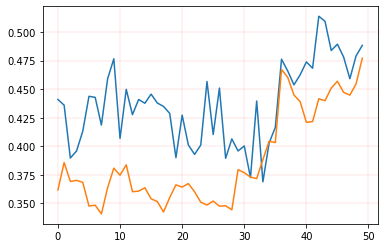

73 tensor(8.7096e-05, device='cuda:0', grad_fn=<MseLossBackward>)


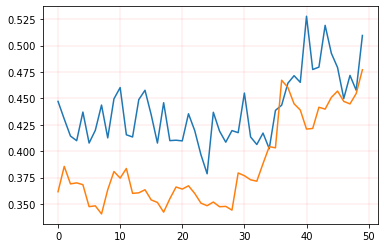

74 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


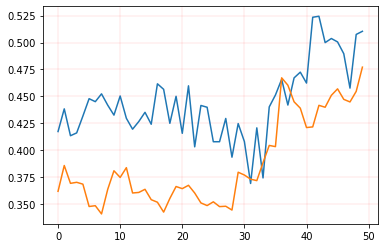

75 tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward>)


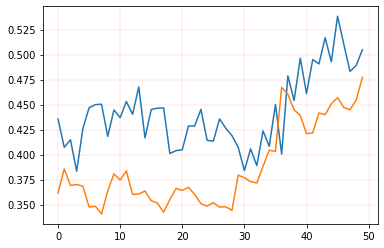

76 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)


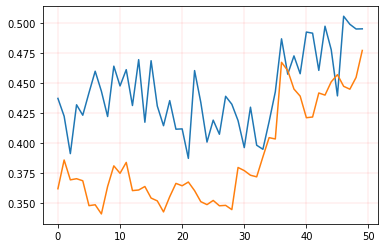

77 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)


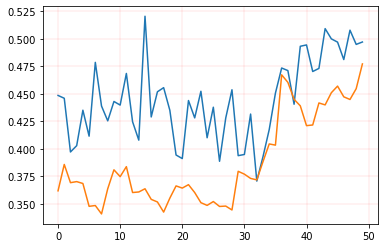

78 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)


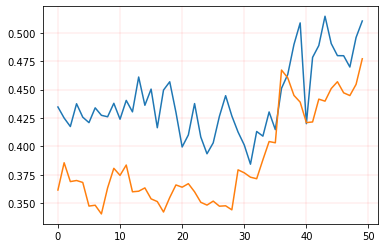

79 tensor(5.2426e-05, device='cuda:0', grad_fn=<MseLossBackward>)


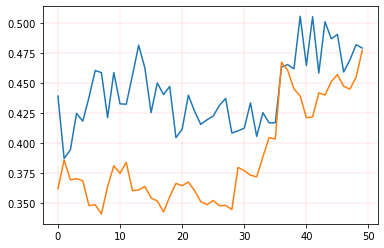

80 tensor(5.8360e-08, device='cuda:0', grad_fn=<MseLossBackward>)


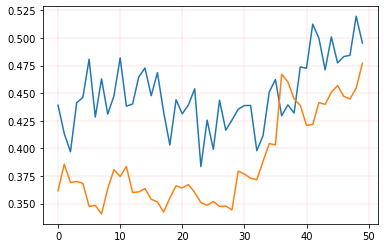

81 tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)


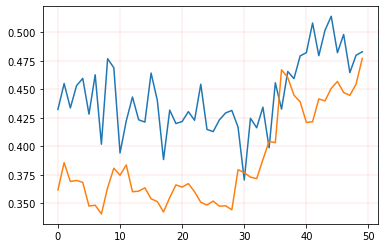

82 tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)


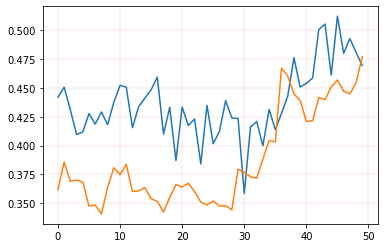

83 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


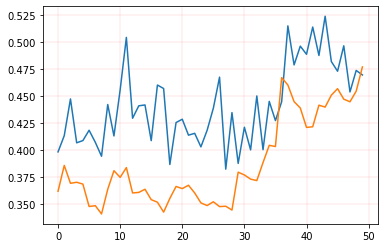

84 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


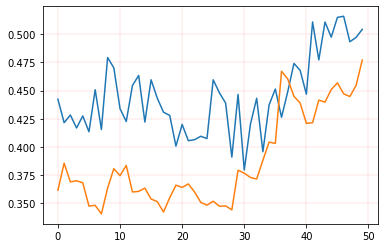

85 tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)


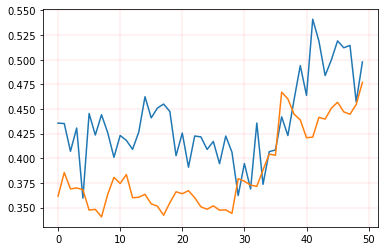

86 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)


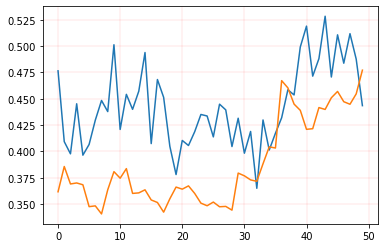

87 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)


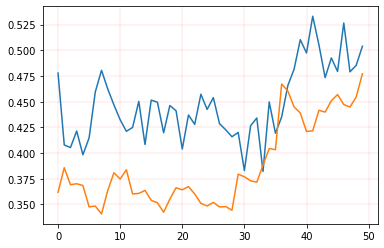

88 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)


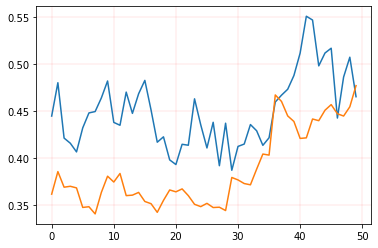

89 tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


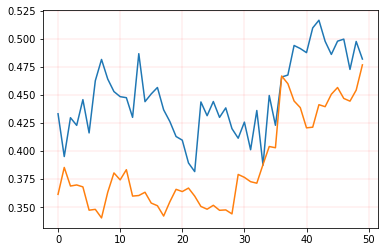

90 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)


KeyboardInterrupt: ignored

In [18]:
epoch = 200
preds_in_learn = []
reals_in_learn = []
optimizer = torch.optim.Adam(instance.parameters(), lr=.000001)
for i in range(epoch):
    for seq, y in train_set:
        instance.reset()
        pred = instance.forward(seq)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    with torch.no_grad():
        for item , y in test:
            preds_in_learn.append(instance.forward(item))
            reals_in_learn.append(y)
    plt.plot(range(50), preds_in_learn[-50:],)
    # plt.show()
    plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
    # plt.show()
    plt.plot(range(50), reals_in_learn[-50:])
    plt.show()
    preds_in_learn.clear()
    reals_in_learn.clear()
    print(i, loss)

In [0]:
test = train_set[-200:]

In [0]:
torch.save(instance.state_dict(),'/content/drive/My Drive/Colab Notebooks/PCA_LSTM_OUT10_32Indicators.pn')

In [0]:
# instance.eval()
preds = []
real = []
with torch.no_grad():
    for item, y in test:
        instance.reset()

        preds.append(instance.forward(item))
        real.append(y)


In [0]:
plt.plot(range(60), preds[-60:],)
# plt.show()
plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
# plt.show()
plt.plot(range(60), real[-60:])
plt.show()